After running 0_data_preproc

In [1]:
%reload_ext autoreload
%autoreload 2
dir_data = '../data/power_consumption/'

# Naive Method - Forecasting

In [2]:
# naive forecast strategies
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# Split Dataset

Splitting Dataset directly as a function and working for Forecasting with it

In [3]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test


# load the new file
dataset = read_csv(dir_data+'household_power_consumption_by_day.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])# load the new file

(159, 7, 8)
3390.46 1309.268
(46, 7, 8)
2083.4539999999997 2197.006


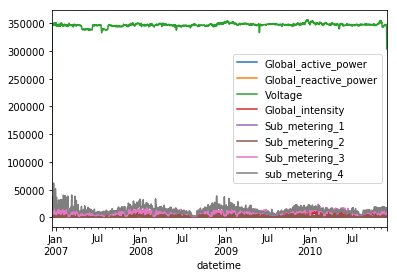

In [4]:
#plot raw-Data
dataset.plot()
pyplot.show()

# Define Evolution Model 

In [5]:
# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# RMSE Calculation 

In [6]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# Daily and Weekly Persistence

In [7]:
# daily persistence model
def daily_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	# get the total active power for the last day
	value = last_week[-1, 0]
	# prepare 7 day forecast
	forecast = [value for _ in range(7)]
	return forecast

# weekly persistence model
def weekly_persistence(history):
	# get the data for the prior week
	last_week = history[-1]
	return last_week[:, 0]

# Run Naive Model (Daily and Weekly)

day: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0


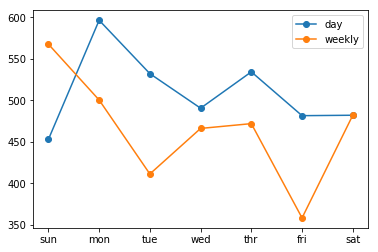

In [8]:
# load the new file
dataset = read_csv(dir_data+'household_power_consumption_by_day.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['day'] = daily_persistence
models['weekly'] = weekly_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()